In [1]:
import pandas as pd
import numpy as np
import functools as fnc
import operator as opr
import warnings

from sqlalchemy import create_engine 

from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator,ClassifierMixin
 
from sklearn.preprocessing import StandardScaler , OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.neural_network import MLPClassifier
import lightgbm as lgb
import catboost as cbs

import torch
import torch.nn as nn

from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score,roc_auc_score,confusion_matrix
import shap
import shap.utils as su

import matplotlib.pyplot as plt

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
multiply = lambda array: fnc.reduce( opr.mul,array,1 )
np.random.seed(499)
torch.use_deterministic_algorithms(True)
torch.manual_seed(499)

## Подключитесь к базе. Загрузите таблицы sql

In [3]:
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
} 

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

engine = create_engine(connection_string) 

#### Загрузка данных для модели

Запрос ниже загружает основной набор данных который будет использован  при моделировании  
Дальше для частных задач будут использвоаться и другие запросы.

Чтобы по возможности облегчить память при работе с довольно большой моделью,   
часть преобразований производится уже при загрузке, в частности   
 категориальные переменные загружаются как строки,
 а неиспользуемые данные опускаются 
 
Я ожидаю, что модель будет предсказывать в момент заказа автомобиля, 
 когда неизвестны характеристики возможной аварии (тип и участники инцидента, направление движения,тяжесть повреждений ),
 но в принципе известны маршрут, время суток  и погода.
Я вижу только 3 числовых признака - возраст авто, сумма страховки и расстояние до трассы.
Время разбивается на месяц, день недели и час (день месяца и минуты вряд ли ан что  влияют ) - и я рассматриваю эти признаки как категориальные. Более корректно наверно переводить их в (сезон, выходной, часть суток), но так как модель предварительная, надо проверить только сам факт возможной зависимости, я ожидаю что такая модель зависимость найдет , есл она есть . 

In [4]:
%%time
query = """
select 
county_city_location as city,
county_location as county,
distance,
--direction,
to_char(intersection,'99') intersection,
weather_1,
location_type,
---------  omit values not known just after incident 
--collision_damage,     
--party_count,
--primary_collision_factor
--pcf_violation_category
--type_of_collision
--motor_vehicle_involved_with
road_surface as surface,
road_condition_1 ,
lighting,
control_device,
to_char(collision_date,'mm') as month ,
to_char(collision_date,'D') as weekday ,
to_char(collision_time,'hh24') as hour,
at_fault,
insurance_premium,
party_sobriety as sobriety,
party_drug_physical as drug,
to_char(cellphone_in_use,'999')  as phone,
vehicle_type,
vehicle_transmission,
vehicle_age
 from collisions c
 join parties p using(case_id)
 join vehicles v using( case_id , party_number)
where party_type = 'car'
 and extract('YEAR' from c.collision_date) = 2012
 and c.collision_damage <> 'SCRATCH'
 and v.vehicle_age is not null
"""

df = pd.read_sql_query(query, con=engine) 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100606 entries, 0 to 100605
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   city                  100606 non-null  object 
 1   county                100606 non-null  object 
 2   distance              100606 non-null  float64
 3   intersection          100273 non-null  object 
 4   weather_1             100306 non-null  object 
 5   location_type         42755 non-null   object 
 6   surface               99851 non-null   object 
 7   road_condition_1      100079 non-null  object 
 8   lighting              100279 non-null  object 
 9   control_device        100144 non-null  object 
 10  month                 100606 non-null  object 
 11  weekday               100606 non-null  object 
 12  hour                  100501 non-null  object 
 13  at_fault              100606 non-null  int64  
 14  insurance_premium     99997 non-null   float64
 15  

## Проведите первичное исследование таблиц

In [5]:
df.isna().sum()

city                        0
county                      0
distance                    0
intersection              333
weather_1                 300
location_type           57851
surface                   755
road_condition_1          527
lighting                  327
control_device            462
month                       0
weekday                     0
hour                      105
at_fault                    0
insurance_premium         609
sobriety                 1539
drug                    96494
phone                    9448
vehicle_type                0
vehicle_transmission     1469
vehicle_age                 0
dtype: int64

Для предварительной оценки не обязательно иметь полные данные
Явно не хватает данных по location_type, direction, phone
Для drug NULL видимо означает отсутствие особых обстоятельств


Почти все колонки категориальные, так что анализ корреляций и разброса значений не имеет смысла.
Всё же выбросы в числовых колонках надо исправить для избежания непрежсказуемых эффектов
Для 0.6% процента инцидентов неизвестна сумма страховки, для первичного исследования можно поставить общую медиану, хотя медианы по городу будут наверно точнее. 

#### Заполнение пустышек

In [6]:
df.insurance_premium.fillna(df.insurance_premium.median())

0         32.0
1         27.0
2         45.0
3         18.0
4         36.0
          ... 
100601    39.0
100602    36.0
100603    39.0
100604    21.0
100605    41.0
Name: insurance_premium, Length: 100606, dtype: float64

In [7]:
df['insurance_premium'] = df.insurance_premium.fillna(df.insurance_premium.median())
df=df.fillna('MISSING')
df.isna().sum()

city                    0
county                  0
distance                0
intersection            0
weather_1               0
location_type           0
surface                 0
road_condition_1        0
lighting                0
control_device          0
month                   0
weekday                 0
hour                    0
at_fault                0
insurance_premium       0
sobriety                0
drug                    0
phone                   0
vehicle_type            0
vehicle_transmission    0
vehicle_age             0
dtype: int64

#### Проверка выбросов 

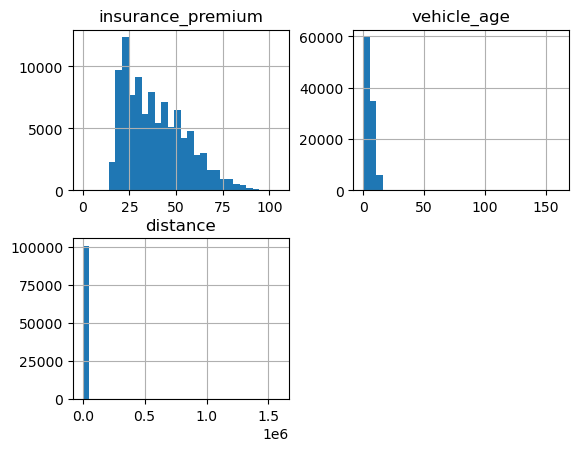

In [8]:
num_columns=['insurance_premium','vehicle_age','distance']
df[num_columns].hist(bins=30);

In [9]:
df[df.vehicle_age>20]

,city,county,distance,intersection,weather_1,location_type,surface,road_condition_1,lighting,control_device,...,weekday,hour,at_fault,insurance_premium,sobriety,drug,phone,vehicle_type,vehicle_transmission,vehicle_age
15405,1942,los angeles,0.0,1,clear,ramp,dry,normal,dusk or dawn,functioning,...,4,05,0,22.0,had not been drinking,MISSING,0,sedan,manual,161
74694,1942,los angeles,449.0,0,clear,MISSING,dry,normal,daylight,none,...,4,11,1,18.0,had not been drinking,MISSING,0,sedan,manual,161


Два выброса по возрасту машины , возможно даже один и тот  же автомобиль.

In [10]:
df.loc[df.vehicle_age>20 ,'vehicle_age'] = df.vehicle_age.median()

по первой  колонке все нормально, вторая исправлена,  третья выглядит странно, но похоже дело в том, что там очень много нулей, а оставшиеся значения сильно размазаны.
Небольшое преобразование показыает что распределение здесь  тоже естественно - логарифмы значений отличных от 0, распределены нормально.


Квантили 0.4 - 0.6 для distance
 0.4     50.0
0.5    100.0
0.6    200.0
Name: distance, dtype: float64


0.3    2.565026
0.4    3.912043
0.5    4.605180
0.6    5.298322
0.7    5.958427
0.8    6.481579
0.9    7.367709
Name: distance, dtype: float64

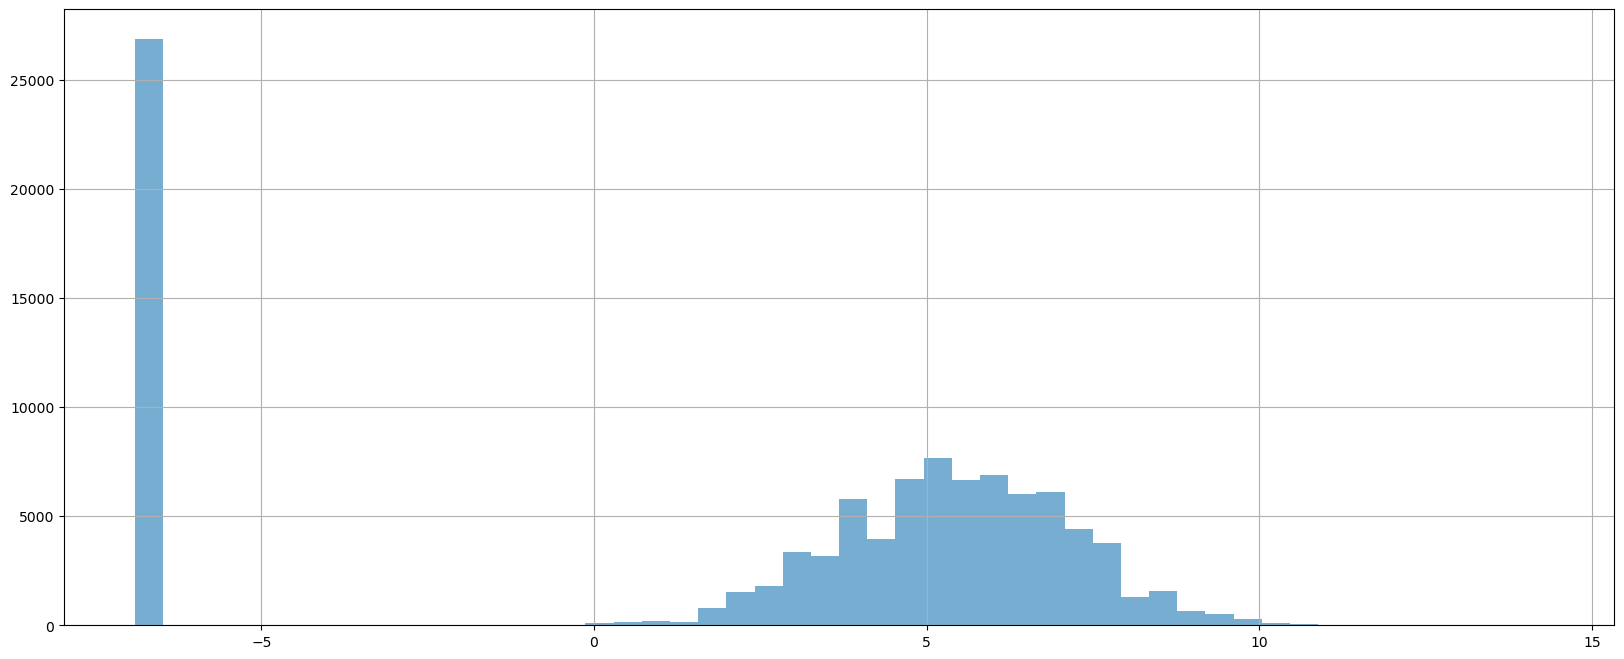

In [11]:
(df.distance+.001).apply(np.log).hist(bins=50,figsize=(20,8),alpha=.6);
print("Квантили 0.4 - 0.6 для distance\n", (df.distance.quantile([.4,.5,.6]) ) )
(df.distance+.001).apply(np.log).quantile(list(np.arange(0.3,1,.1)) )

Однако расстояния  10тыс км от трассы невозможны, да и 1000 км много для Калифорнии, но такие цифры есть и распределены естественно
Их 10% и не хочется их выбрасывать (хотя на разведочной оценке пока наверно можно), и их нельзя оставлять, потому что это большие сдвиги вверх и они исказят картину

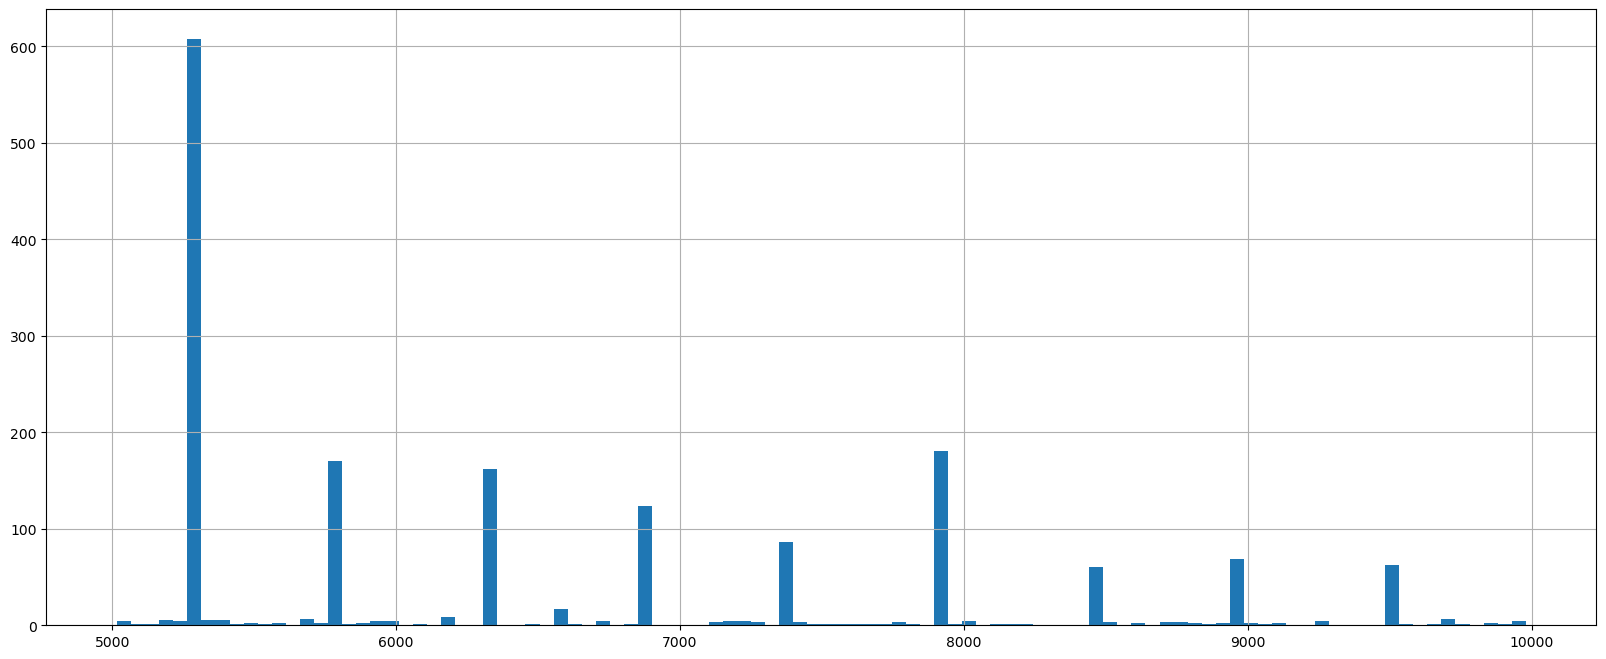

In [12]:
df.distance[(df.distance > 5_000) & (df.distance<10_000)].hist(figsize=(20,8),bins=100);

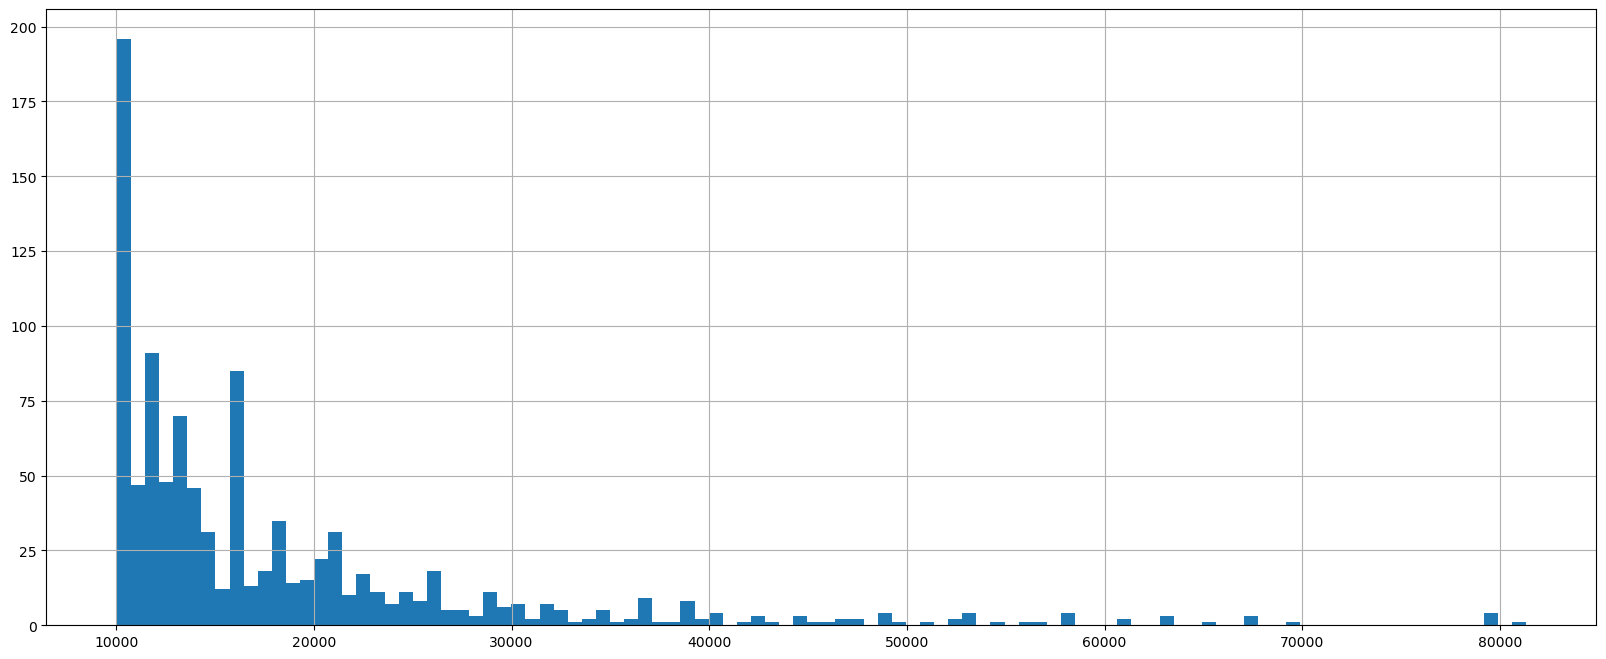

In [13]:
df.distance[(df.distance > 10_000) & (df.distance<100_000)].hist(figsize=(20,8),bins=100);

Мы получим целые числа на пиках, если разделим distance на 1056

In [14]:
(df[df.distance> 1000].distance/1056).value_counts().head(20)

distance
1.000000     2372
1.500000     1738
2.500000     1609
2.000000     1052
5.000000      603
1.250000      590
1.420455      536
3.000000      505
3.500000      361
1.136364      323
1.893939      314
4.000000      307
4.500000      199
7.500000      181
5.500000      166
6.000000      162
10.000000     155
2.367424      147
6.500000      124
1.041667      124
Name: count, dtype: int64

А распределение по большим дистанциям будет очень напоминать базовое,если дистанцию поделить на 10.56

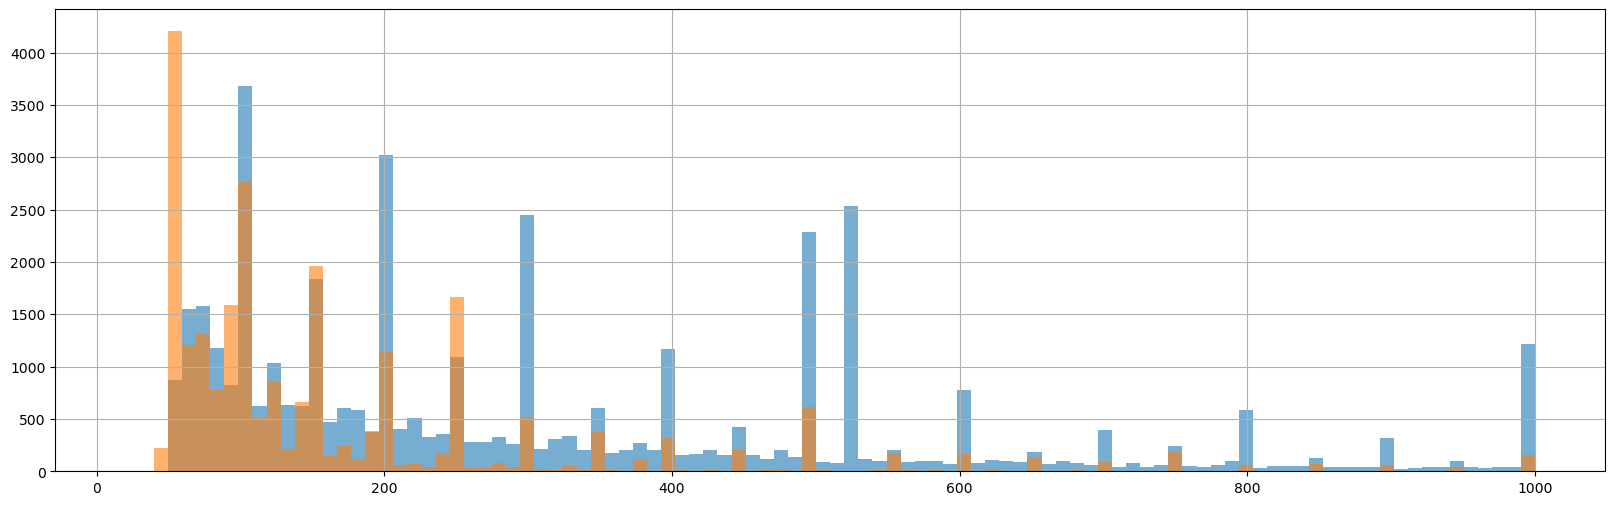

In [15]:
(df[df.distance> 50].distance).hist(figsize=(20,6),bins=100,range=(20,1000),alpha=.6);
(df[df.distance> 500].distance/10.56).hist(figsize=(20,6),bins=100,range=(20,1000),alpha=.6);


В общем, я не знаю, что это такое, может какой-то кривой перевод в мили, но при таких совпадениях я думаю можно верить числам даже без понимания того, что они означают. Так что в это ситуации я считаю лучшим решением поделить на 10.56 дистанции > 500  

In [16]:
df['distance']=df.distance.apply(lambda d: [d,d/10.56][d>500] )

Осталось полпроцента записей с нереальной дистанцией, для которых трудно найти закономерность, поэтому я поставлю им медиану(но по ненулевым значениям, т.к. здесь явно не нули )

In [17]:
df['distance']=df.distance.where(df.distance<1500, other=df[df.distance>0].distance.median())

##  Проведите статистический анализ факторов ДТП

для общего понимания ситуации оценим распространённость целевого признака

In [18]:
df.at_fault.mean()

0.44660358229131464

### Вред пьянства

Естественно предположить, что степень  очень сильно влияет на назначение виновника, и в общем, так оно и есть -   
пьяный признается виновным в 95 % случившихся с ним происшествий, слегка выпивший - в 71% , неясные ситуации располагаются по степени уверенности в пьянстве.   
Вероятно нужна какая-то наглядная диаграмма, но я даже не уверен, что правильно показывать - хотя пьяный почти всегда виноват, доля инцидентов с ними невелика и в общем итоге возможно мало влияет.

In [19]:
df.groupby('sobriety').at_fault.agg(['count','mean']).sort_values(by='mean',ascending=False)

,count,mean
sobriety,,
"had been drinking, under influence",5413,0.956586
"had been drinking, impairment unknown",319,0.811912
impairment unknown,1621,0.732264
"had been drinking, not under influence",801,0.714107
MISSING,1539,0.644574
had not been drinking,90321,0.404524
not applicable,592,0.347973


<b>Примечание</b>   
В задании требуется показать <i> зависимость числа ДТП от уровня трезвости </i>  
Честно говоря не понял, что имеется в виду, так как безаварийной статистики у нас нет и сравнивать статистику аварий не с чем .  
Требуется показать для каждой категории аварий/ повреждений долю пьяных в ней ?

#### Зависимость ДТП от суммы страховки

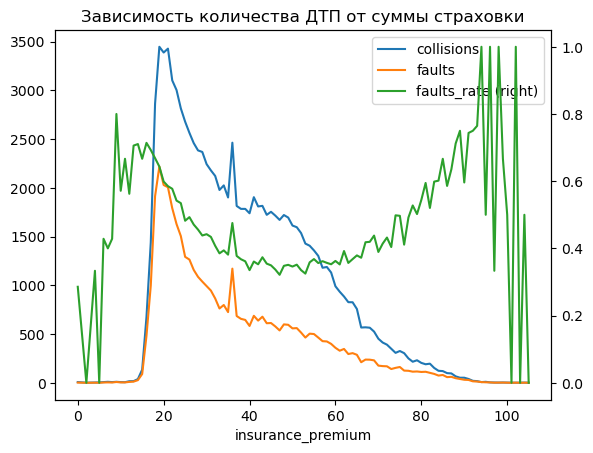

In [20]:
df_ip = df.groupby('insurance_premium').at_fault.agg(['count','sum', 'mean'])
df_ip.columns = ['collisions','faults','faults_rate']
df_ip.plot(secondary_y=['faults_rate'],title='Зависимость количества ДТП от суммы страховки');

Зависмость сложная. Видимо средний класс использует страховки на суммы $20-40K  
В этих пределах доля виновности  падает со стоимостью страховки.  
Но вне этих пределов она наоборот растёт!

#### Зависимость ДТП от возраста автомобиля

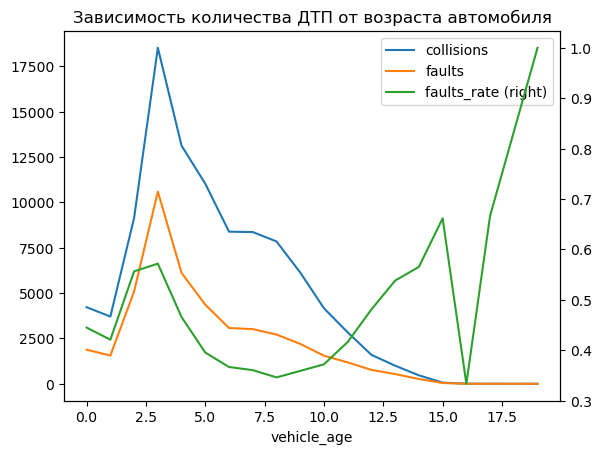

In [21]:
df_va = df.groupby('vehicle_age').at_fault.agg(['count','sum', 'mean'])
df_va.columns = ['collisions','faults','faults_rate']
df_va.plot(secondary_y=['faults_rate'],title='Зависимость количества ДТП от возраста автомобиля');


In [22]:
df_va

,collisions,faults,faults_rate
vehicle_age,,,
0,4222,1878,0.444813
1,3705,1559,0.420783
2,9146,5089,0.556418
3,18521,10588,0.571675
4,13123,6110,0.465595
5,11026,4358,0.395248
6,8385,3074,0.366607
7,8363,3014,0.360397
8,7847,2715,0.345992


Доля виновности минимальна для автомобилей возраста 5-10 лет и поднимается для крайних значений.  
Можно строить предположения о причинах, но  основной гипотезы нет.

### Распределение ДТП по месяцам

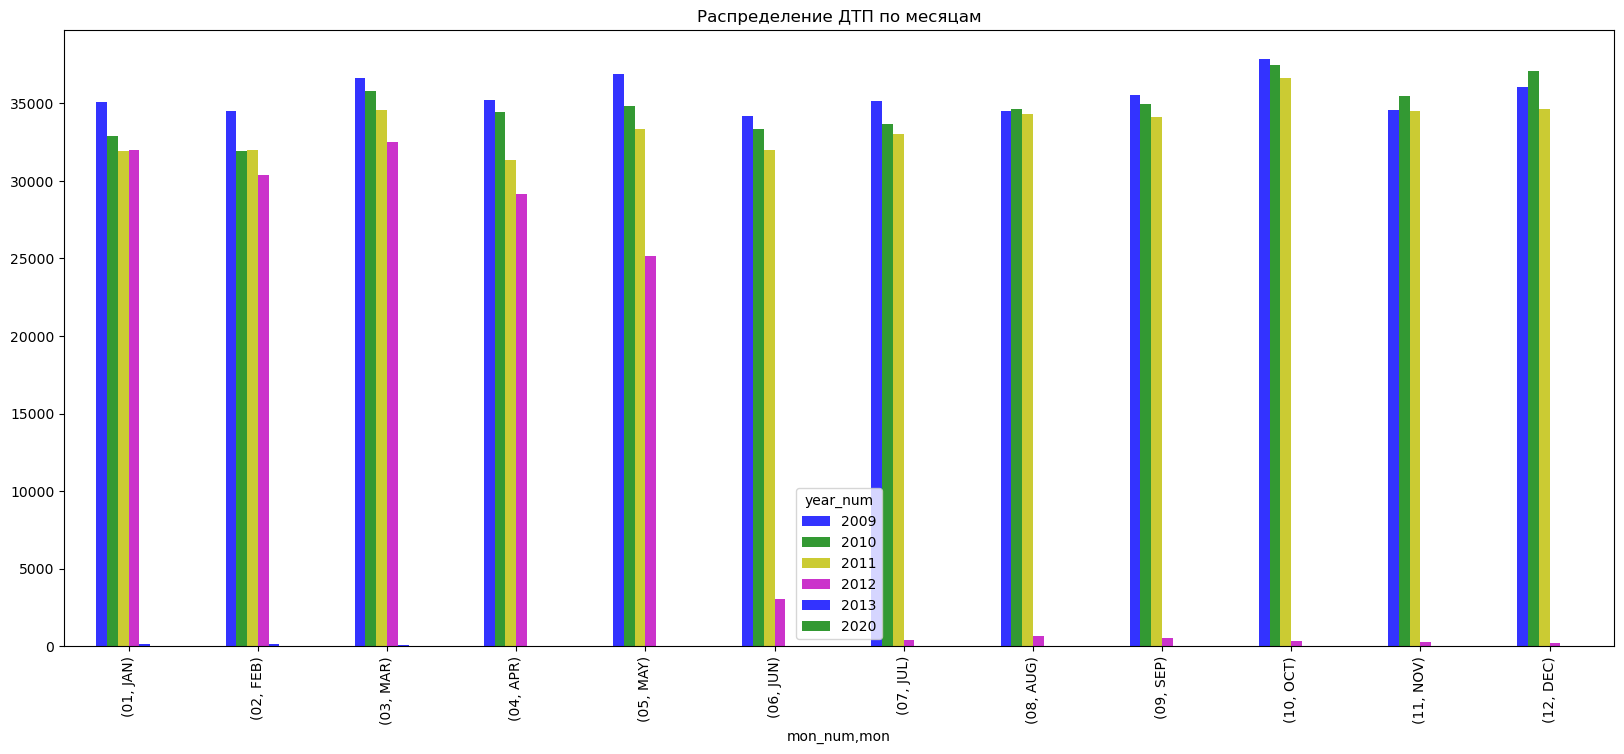

In [23]:
query = f"""
select to_char(collision_date,'YYYY') year_num,
       to_char(collision_date,'MM') mon_num,
       to_char(collision_date,'MON') mon,
       count(*) qty
  from collisions c
  where  c.collision_damage <> 'SCRATCH'
  group by 1,2,3 
  order by 2,1
"""
dm = pd.read_sql_query(query,con=engine)
dm =dm.pivot_table( index=['mon_num','mon'], columns='year_num', values= 'qty')
dm.plot.bar(title='Распределение ДТП по месяцам',
            color=['b','g','y','m'],
            alpha=.8,
            figsize=(20,8)
           );


Существуют небольшие пики в марте и конце года, но самое главное - за 2012 год данные только до июня!  

Это обесценивает требование использовать 2012 для анализа - надо или расширять данные за этот год или откатываться на предыдущий - осенью вполне может быть анаомалия, которую мы не увидим.

###  Распределение ДТП по причинам

Иллюстративный запрос, который не может быть прямо  использован в модели (так как оба фактора неизвестны на момент предсказания), но косвенно может помочь в определении критических точек. 

In [24]:
query = '''
select pcf_violation_category,count(*) qty
 from collisions c 
 join parties p using(case_id)
 where  extract('YEAR' from c.collision_date) = 2012
  and c.collision_damage <> 'SCRATCH'
  and p.at_fault=1
 group by 1
 order by 2 desc
'''
dr = pd.read_sql_query(query,con=engine)
cutoff = .05
dr =  dr.set_index(dr.pcf_violation_category).qty 
dr  = pd.concat([dr[dr/dr.sum()>= cutoff] ,
           pd.Series( dr[dr/dr.sum()<cutoff].sum(),index=['OTHER'] )])

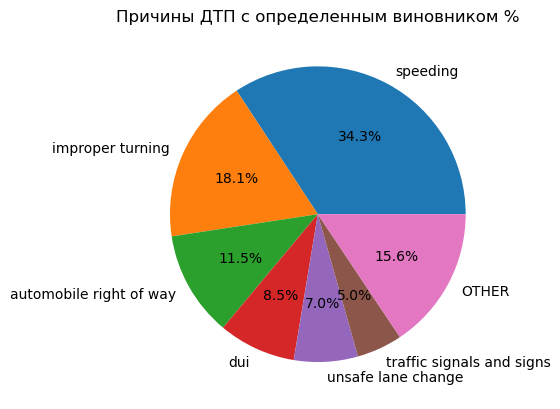

In [25]:
dr.plot.pie(autopct='%1.1f%%',title='Причины ДТП c определенным виновником %');

Половина инцидентов происходит по двум причинам - превышение скорости и неправильный поворот. Можно рассмотреть отслеживание скорости онлайн и какой-нибудь доступ к камерам на перекрёстках.

Третья по частоте причина как я понимаю - нарушение порядка проезда, так что можно ещё принимать экспресс-экзамен по ПДД :) 

### Список задач для рабочей группы

Необходимо отобрать для анализа наиболее важные для нас признаки, влиящие на ДТП  

Признаки можно разделить на объективные (одинаково относящиеся ко всем участникам ) и субъективные (различающиеся для участников). Объективные  признаки  хранятся в таблице collisions, субъективные - в таблицах parties  и vehicles.

Проблема анализа объективных признаков в том, что они мало помогают в реализации основной идеи заказчика - предсказанию вины конкретного участника.  
Объективные признаки могли бы помочь в предсказании вероятности аварии , но у нас нет данных о частоте аварий и о продолжительности беаварийной езды. Косвенно, влияние объективных признаков можно оценить по серьезности инцидентов в группе и по количеству инцидентов с одним участником.  

Субъективные признаков хорошо помогают в реализации основной идеи, но их слишком мало, чтобы строить серьехную модель, так что в дкльнейшем видимо придётся как-то привлекать объективные признаки. 

Также следует оценить возможные дополнительные целевые признаки, которые могут представлять интерес для заказчика, в частности ущерб collision_damage  и возможно primary_collision_factor и violation_category (от них может зависеть размер страховых выплат) . Эти признаки неизвестны в момент предсказания и в любом случае не могут  быть учтены в модели, но могут быть предсказаны. 

Окончательная постановка задачи зависит от того, что хояет получить заказчик, здесь есть некоторая неясность -   
с одной стороны, надо предсказывать вероятность аварии в конкретной ситуации, для чего не хватет данных 
с другой - предсказывать виновника, для чего годится только несколько признаков из таблицы parties.

Я также  предполагаю, что интересует не только виновник, но и потенциальный ущерб от него , но пока задача так не ставится и нет целевой функции (ущерб можно предположить по размерам страховки, но непонятно какой реальный ущерб несёт в каждом случае компания). 

Предварительно, я бы выделил такие задачи (список будет уточнён по резултатам моделирования)
* Установить связь между физическим состоянием участника ДТП (трезвость, степень опъянения и усталость)  и виновностью , а также тяжестью аварии
* Проверить наличие связи между суммой страховки и виновностью, а также тяжести повреждений
* Доля в общей стоимости инцидентов (понимаемой как сумма страховки) различных субъективных причин(по крайней мере пьянства и возраста автомобиля)

* Проверить наличие связи между локацией (город + графство) и виновностью водителя в ДТП с одним участником.
* Прверить связь между локацией и причинённым ущербом
* Есть ли локации,  доля которых в авариях выросла за время наблюдений?

## Создайте модель для оценки водительского риска

Выбор признаков для модели описан в комментарии к основному запросу данных для модели, часть 2

Я стремился работать с моделями по возможности одинаково, убирая код в стандартыне классы, так чтобы различались тольок тип модели и решетка параметров. Для градиентного бустинга выбраны модели LGBM  и Catboost, для нейросети - MLP. Насколько я понял из документации, при поиске оптимума все градиентные алгоритмы бинарной классификации используют оценку log_loss/cross_entropy. 
Для каждой модели  запускается кроссвалидация на тренировочном наборе и лучший набор параметров проверяется на тестовом наборе.   
Затем формируются  графики зависимости от параметров.
Для оценки влияния признаков используется билиотека SHAP

### Вспомогательные классы для обучения модели и анализа результата

Вспомогательные классы для сбора результатов кроссвалидации и их отрисовки

#### Parsed Result

Этот класс собрает из результатов кроссвалидации фрейм с мультииндексомм по колонкам,
соответвующим нетривиальным слоям тестируемой решетки. 

In [26]:
class ParsedResult:
    def __init__(self,result,force_string_cols=[]):
        self.df = pd.DataFrame.from_dict( 
            { k:v for k,v in result.items() if k not in ['params']}
        )
# drop param_ prefix from column names for tidy display         
        param_names = [ c for c in self.df.columns if c[:6]=='param_' ]        
        self.param_cols = [ c[6:] for c in param_names ]              
        self.df = self.df.rename( columns={ p:c for p,c in zip(param_names,self.param_cols) } )
# also drop model_ prefix which we use for model grid in pipeline   
        model_names = [ c for c in self.df.columns if c[:7]=='model__' ]
        self.param_cols = [c[7:]  if c[:7]=='model__' else c for c in self.param_cols ]
        self.model_cols = [ c[7:] for c in model_names ]   
        self.df = self.df.rename( columns={ p:c for p,c in zip(model_names,self.model_cols) } )
# select parameters, for which tested several values and arrange them descending (by number of differnt values)
        values_per_cols = list(zip( self.param_cols,[ len( np.unique( self.df[c].values ) ) for c in self.param_cols]))
        self.multi_value_cols =[it[0] for it in sorted(values_per_cols, key=lambda pair:pair[1],reverse=True) if it[1]>1 ]
# some object columns may be not string (f.e. lists)
        for c in force_string_cols:
            self.df[c]=self.df[c].apply(str)
    
    def select(self, index,values=['mean_test_score'],filters={},agg=[] ):
        if len(filters)>0 :
            condition = 'and'.join([ f" {k}=={v} " for k,v in filters.items() ]) 
            filtered = self.df.query(condition)    
        else:
            filtered = self.df
        cols = [ c for c in self.multi_value_cols if c not in list(filters.keys())+[index]+values ]      
        return(self.df.pivot_table(index=index,values=values,columns=cols)  )

#### ResultPlotter

Два класса для отрисовки графиков :    
Вспомогательный класс формирования аттрибутов линий для графиков, создаваемых в основном плоттере

In [27]:
class Styler:
    base_array=[]
    def __init__(self,param_array=[]):
        self.params = [ self.base_array,param_array][bool(param_array)]
    
    def key(self):
        pass
    
    def put(self,dct,index):
        dct[self.key()] = self.params[index]
        
class ColorStyler(Styler):
    base_array=[*'rgbykm']
    def key(self):
        return('color')

class DashStyler(Styler):
    base_array=['--',':','-.','-']
    def key(self):
        return('ls')
    
class WidthStyler(Styler):
    base_array=[ 2,4,7]
    def key(self):
        return('lw')

class AlphasStyler(Styler):
    base_array=[ .3,.9]
    def key(self):
        return('alpha')
    

И собственно плоттер, рисующий каждый столбец мультиколонки в своем стиле.   
Отельные непересекающиеся аттрибуты создаются для каждого уровня мультиколонки,   
в результате каждая элементарная подколонка получает уникальный стиль   

In [28]:
class ResultPlotter:
    base_params = {
        'colors':[*'rgbykm'],
        'styles':['--',':','-.','-'],
        'widths':[ 2,4,7],
        'alphas':[.3,.8],
        'figsize': (20,8),
        'logscale':""
    }
    
    def __init__(self, test, params = {} ):
        self.model = test.model
        self.df= test.sel
        self.params=self.base_params | params
        self.stylers = [ColorStyler(self.params['colors']),DashStyler(self.params['styles']),
                        WidthStyler(self.params['widths']),AlphasStyler(self.params['alphas'])]
        self.mcols = self.df.columns
        self.lev_names = self.mcols.names[1:]
        self.num_levels= len(self.lev_names)
        self.level_sizes=[ len(set(self.mcols.get_level_values(x))) for x in self.lev_names]

# auxliary func to forms sequence of indexes for levels
# result is need index on the level  which may be one of color|dashstyle|linewidth
    def idx_on_level(self,idx, lev_num):
        items_on_hyperplane = multiply(self.level_sizes[(lev_num+1):]) 
        return idx//items_on_hyperplane% self.level_sizes[lev_num]
    
    def plot(self):
        fig,ax = plt.subplots(figsize=(20,6))
        if 'x' in self.params['logscale'].lower():
            ax.set_xscale('log')
        
        for i in range(len( self.mcols)):
            graph_params = {}
            for i_level in range(self.num_levels):
                self.stylers[i_level].put( graph_params, self.idx_on_level(i,i_level) ) 
            idx=self.mcols[i]
            
            graph_params['label'] = ','.join( [ f"{n}:{i} " for n,i in zip(self.lev_names,idx[1:]) ] )
            ax.plot(self.df[idx] ,**graph_params)
            ax.set_title(f'Тест {type(self.model).__name__}')
            ax.set_xlabel('learning rate')
            ax.set_ylabel('log_loss metric')
            ax.legend()

#### Класс для универсального теста на модели

Содержит программу стандартного теста

In [29]:
class TestModel:
    def __init__(self, model,fit_params={} ):
        self.model = model
        self.fit_params=fit_params
        
    def cross_validate(self,param_grid,X_tr,y_tr):
        self.cv = GridSearchCV(self.model, param_grid, cv=4, return_train_score=True ) 
        self.cv.fit(X_tr,y_tr,**self.fit_params)
        self.best = self.cv.best_params_
        return self.best
    
    def check_best(self,X_tr,y_tr,X_te,y_te):
        model = self.model.set_params(**self.best)
        model.fit(X_tr,y_tr,**self.fit_params)
        pr = model.predict(X_te)
        for metric in [f1_score,precision_score,recall_score,accuracy_score]:
            print(f"{metric.__name__}: {metric(y_te,pr)} \t")
        return confusion_matrix(y_te,pr)   
    
    def parse_result(self,index_column='learning_rate',forced_string_cols=[]):
        self.res = ParsedResult(self.cv.cv_results_,forced_string_cols)
        self.sel = self.res.select(index_column)
        return self.sel
        
    def plot(self):
        self.rp = ResultPlotter(self,{'logscale':'x'})
        self.rp.plot()
         

### Описание структуры данных и  разбиение на тренажер и тест

In [30]:
y = 'at_fault'
X = [ c for  c in df.columns if c!=y ]
cat_cols = [ c for c in df.columns if df.dtypes[c] == 'object'  ] 
num_cols = [ c for c in df.columns if df.dtypes[c] in ['int64','float' ] ]

In [31]:
for c in cat_cols:
    df[c] = df[c].astype('category')


In [32]:
X_tr,X_te,y_tr,y_te = train_test_split(df[X],df[y], test_size = .25, stratify = df[y], shuffle= True ) 

#### LGBM

In [33]:
%%time
params_grid = {
    'subsample':[.25],
    'subsample_freq':[4],
    'objective':['binary'],
    'is_unbalance':[True,False],
    'learning_rate': [.3,.1,.03,.01,.003],
    'n_estimators': [128,256,512],
#    'n_estimators':[16],
    'boosting' :['gbdt','dart'],
    'max_depth':  [256],
    'num_leaves': [512]       
}
lgbm = TestModel(lgb.LGBMClassifier( verbose = -1))
lgbm.cross_validate(params_grid,X_tr,y_tr)

CPU times: user 3h 24min 58s, sys: 21.2 s, total: 3h 25min 19s
Wall time: 51min 20s


{'boosting': 'gbdt',
 'is_unbalance': False,
 'learning_rate': 0.003,
 'max_depth': 256,
 'n_estimators': 512,
 'num_leaves': 512,
 'objective': 'binary',
 'subsample': 0.25,
 'subsample_freq': 4}

In [34]:
lgbm.check_best(X_tr,y_tr,X_te,y_te)

f1_score: 0.5401483924154987 	
precision_score: 0.7058316575696639 	
recall_score: 0.43746105225674353 	
accuracy_score: 0.6673425572519084 	


array([[11871,  2048],
       [ 6319,  4914]])

Как и во всех последующих моделях, матрица ошибок перекошена в сторону FN 

In [35]:
lgbm.parse_result()

mean_test_score                                          \
n_estimators              128                                     256   
boosting                 dart                gbdt                dart   
is_unbalance            False     True      False     True      False   
learning_rate                                                           
0.003                0.645188  0.652663  0.653087  0.660773  0.664365   
0.010                0.664670  0.663967  0.665717  0.662046  0.665717   
0.030                0.663490  0.657208  0.657526  0.649853  0.663013   
0.100                0.646248  0.640390  0.624102  0.613831  0.638124   
0.300                0.605375  0.601201  0.586278  0.580764  0.598895   

                                                                           \
n_estimators                                      512                       
boosting                     gbdt                dart                gbdt   
is_unbalance      True      False     True      False     True      False   
learning_rate                                                               
0.003          0.664617  0.664405  0.665306  0.666777  0.662443  0.667082   
0.010          0.660946  0.664365  0.659355  0.665664  0.659422  0.659766   
0.030          0.655512  0.648448  0.641662  0.656943  0.648236  0.635513   
0.100          0.632531  0.610716  0.605283  0.626620  0.617780  0.603798   
0.300          0.596403  0.582262  0.576815  0.590400  0.589392  0.581016   

                         
n_estimators             
boosting                 
is_unbalance      True   
learning_rate            
0.003          0.662337  
0.010          0.651191  
0.030          0.629284  
0.100          0.599809  
0.300          0.580195

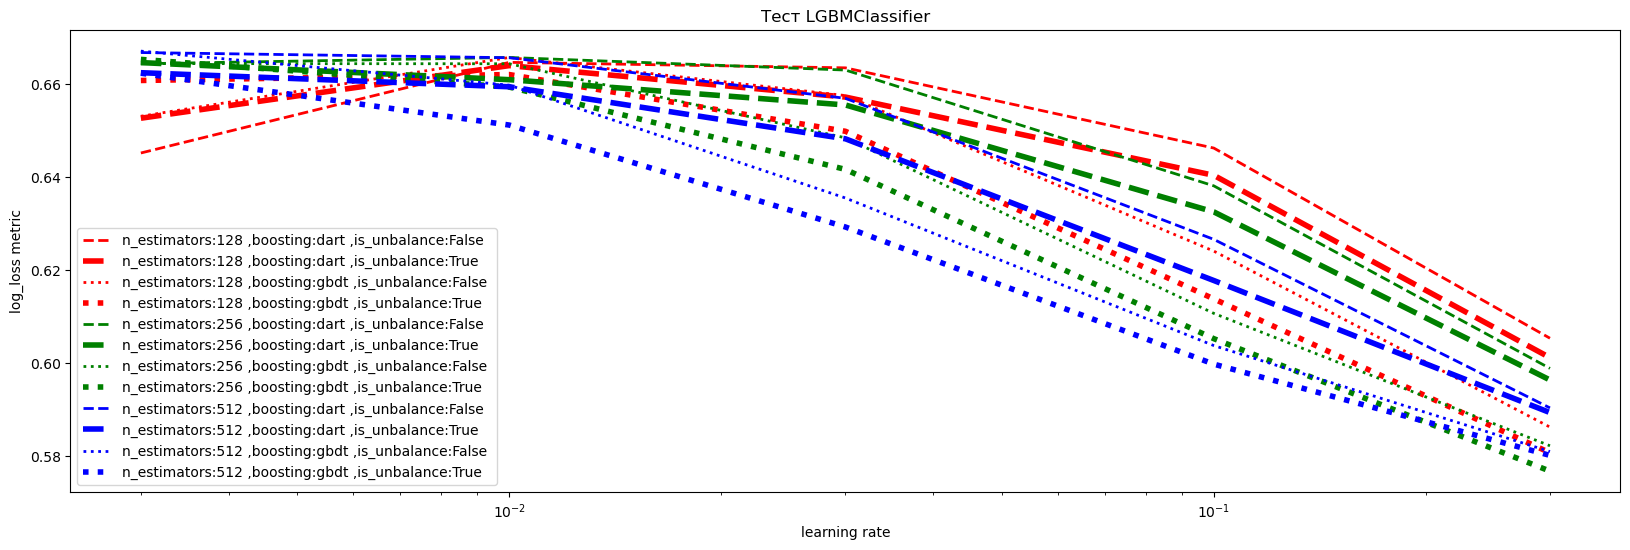

In [36]:
lgbm.plot()

Модель позволяет получить метрику ~0.66 при скоростях обучения 0.03-0.1  
Этот результат стабилен и мало зависит от других параметров

#### Catboost

Хотя модель позволяет задавть не только функцию потерь но и финальную метрику, похоже при тренировке/кроссвалидации этот параметр не учитывется и в качестве test_score выводится функция потерь. 
Но это позовляет сравнить графики CatBoost  и LGBM напрямую

In [37]:
cbst = TestModel(cbs.CatBoostClassifier(logging_level='Silent' ),fit_params={'cat_features':cat_cols})
params_grid = {
    'loss_function' :['Logloss'],
    'eval_metric':['F1'],
    'scale_pos_weight':[.5,1,2],
    'iterations': [64,128,256,512],
#    'iterations': [64],
    'learning_rate': [.6,.3,.1,.03,.01,.003]
}
cbst.cross_validate(params_grid,X_tr,y_tr)

{'eval_metric': 'F1',
 'iterations': 512,
 'learning_rate': 0.1,
 'loss_function': 'Logloss',
 'scale_pos_weight': 1}

In [38]:
cbst.check_best(X_tr,y_tr,X_te,y_te)

f1_score: 0.597055730809674 	
precision_score: 0.7291639912674971 	
recall_score: 0.5054749399091961 	
accuracy_score: 0.69529262086514 	


array([[11810,  2109],
       [ 5555,  5678]])

Модель также перекошена в строну FN. Точность немного выше чем у LGBM 

In [39]:
cbst.parse_result()

mean_test_score                                          \
iterations                   64                            128             
scale_pos_weight             0.5       1.0       2.0       0.5       1.0   
learning_rate                                                              
0.003                   0.626382  0.653829  0.531595  0.626382  0.654862   
0.010                   0.626209  0.655114  0.532907  0.627654  0.658057   
0.030                   0.629536  0.661118  0.552071  0.636401  0.665849   
0.100                   0.641344  0.667705  0.588279  0.644565  0.668778   
0.300                   0.646221  0.669255  0.598815  0.647693  0.668911   
0.600                   0.648793  0.667201  0.599822  0.649495  0.665160   

                                                                              \
iterations                       256                           512             
scale_pos_weight       2.0       0.5       1.0       2.0       0.5       1.0   
learning_rate                                                                  
0.003             0.532483  0.627058  0.658136  0.531410  0.629019  0.661250   
0.010             0.532205  0.633432  0.666035  0.569963  0.640894  0.671522   
0.030             0.581308  0.644432  0.675126  0.602897  0.652358  0.682972   
0.100             0.596801  0.656281  0.685994  0.629761  0.658865  0.687213   
0.300             0.600339  0.659528  0.686418  0.632213  0.664153  0.684788   
0.600             0.600445  0.661900  0.681528  0.627402  0.664113  0.674133   

                            
iterations                  
scale_pos_weight       2.0  
learning_rate               
0.003             0.552946  
0.010             0.589989  
0.030             0.622154  
0.100             0.634651  
0.300             0.637342  
0.600             0.629629

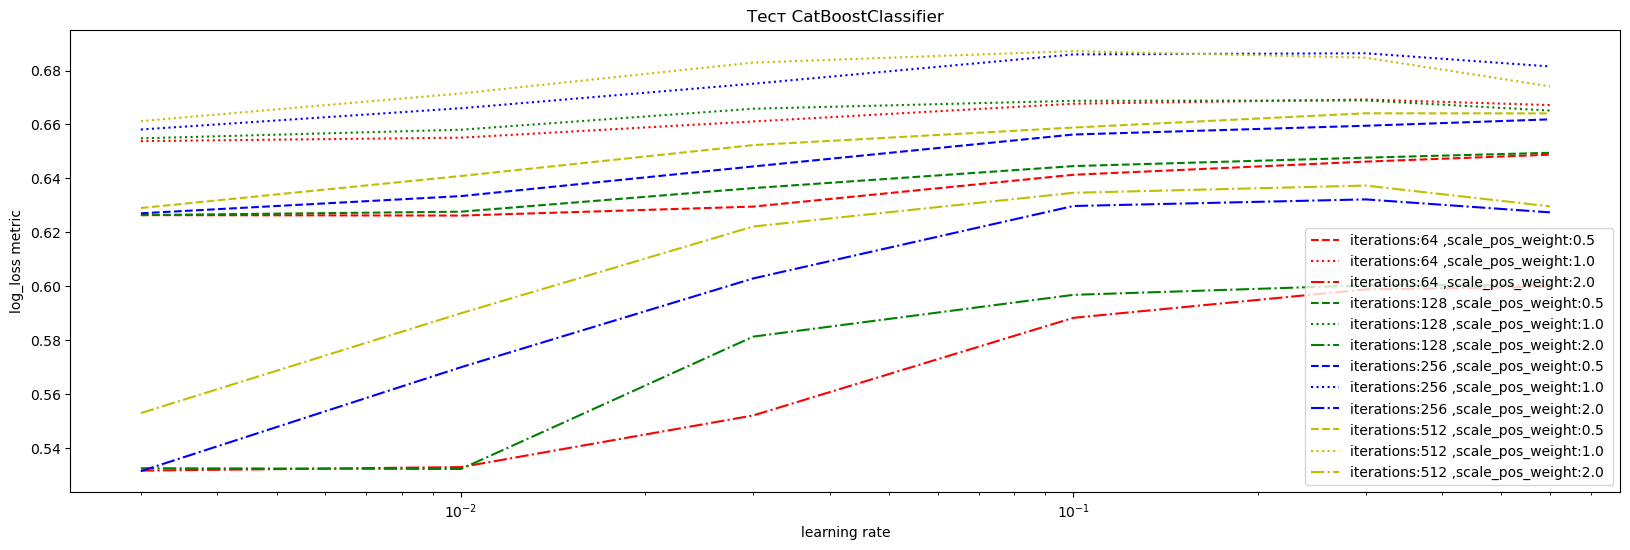

In [40]:
cbst.plot()

Модель позволяет получить метрику ~0.68 при скоростях обучения 0.1-0.3  
Увличение итераций позволяет улучшить модель, также максимумы смещены в правый край диаграммы  и там четкого спада нет  
Возможно модель немного недообучена, но увеличивать обучение можно только количеством итераций и она становится медленной.  
Попытка учесть дисбаланс сильно ухудшает метрику 

#### MLPClassifier

Для унификации расчета и использования одного набора данных  трансформеры убраны в пайплайн.
Проверялись трехуровневая и одноуровневая модели.  
Также не предварительрных тестах проверялся оптимизатор lbfgs но он не показал никаких преимуществ и был критически медленным на трехуровневой модели.  
Я не неашел возможности поставить разные активаторы на разных уровнях и так как для классификации последним должен быть logistic(сигмоид) выбора здесь практически нет ,  

In [41]:
%%time
ohe_pipe = OneHotEncoder(min_frequency =5_000,handle_unknown='infrequent_if_exist')
ctr_pipe = ColumnTransformer( 
        [('encoder-scaler', ohe_pipe, cat_cols)], 
        remainder=StandardScaler(),
        verbose_feature_names_out = False
    )
mlp_pipe =  Pipeline(steps = [
    ['encoder',  ctr_pipe  ],
    ['model',MLPClassifier( max_iter=1_000)]
])
mlp = TestModel(mlp_pipe)
params_grid = {
   'model__hidden_layer_sizes':[ [8], [24,8,4] ],
   'model__solver': ['adam'],
   'model__activation': ['logistic'],
   'model__early_stopping': [ True],
   'model__learning_rate_init':  [.3,.1,.03,.01,.003]  
}

mlp.cross_validate(params_grid,X_tr,y_tr )

CPU times: user 7min 40s, sys: 3.49 s, total: 7min 43s
Wall time: 2min 8s


{'model__activation': 'logistic',
 'model__early_stopping': True,
 'model__hidden_layer_sizes': [8],
 'model__learning_rate_init': 0.003,
 'model__solver': 'adam'}

In [42]:
mlp.check_best(X_tr,y_tr,X_te,y_te)

f1_score: 0.5438416184345757 	
precision_score: 0.6929969671905156 	
recall_score: 0.44752069794355914 	
accuracy_score: 0.6647185114503816 	


array([[11692,  2227],
       [ 6206,  5027]])

Результат на уровне LGBM

In [43]:
mlp.parse_result( index_column='learning_rate_init',forced_string_cols=['hidden_layer_sizes'] )

mean_test_score          
hidden_layer_sizes      [24, 8, 4]       [8]
learning_rate_init                          
0.003                     0.660972  0.662814
0.010                     0.660879  0.662483
0.030                     0.658732  0.661251
0.100                     0.658269  0.657195
0.300                     0.558990  0.647096

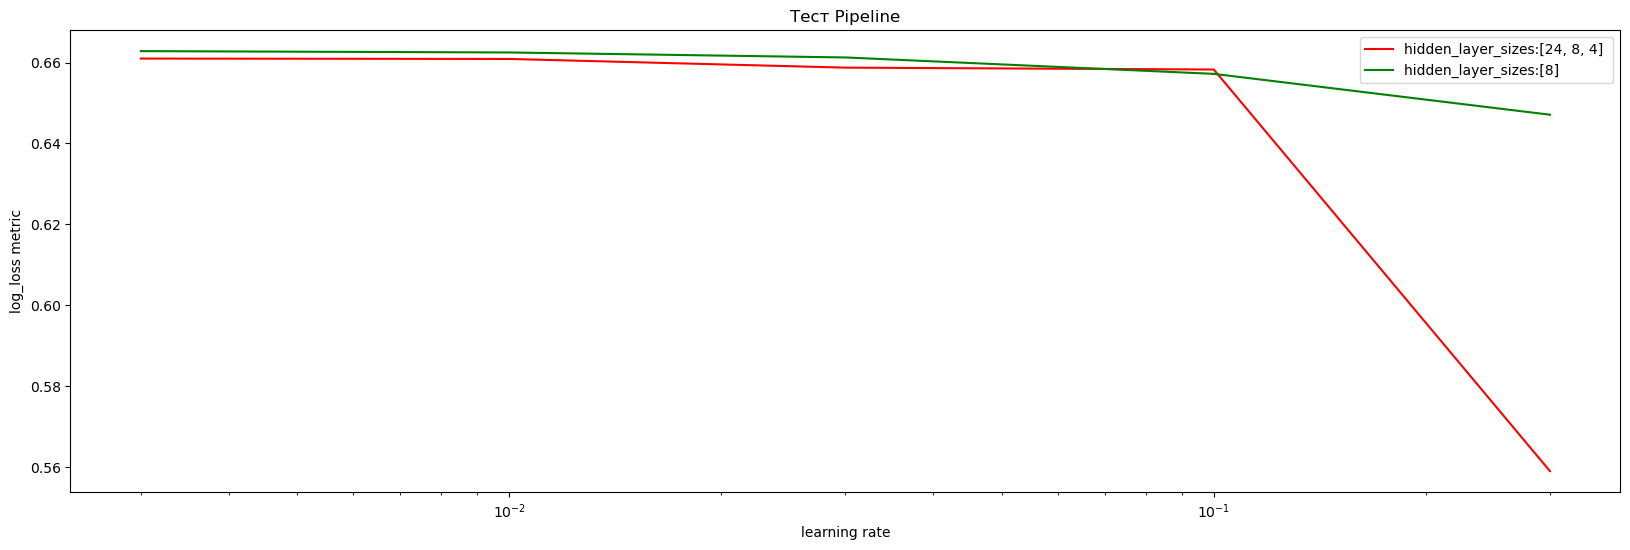

In [44]:
mlp.plot()

Увеличение количества уровней не улучшило модель 
В целом по предварительным результатам нейросеть проигрывывает CatBoost, хотя у нейросети может быть многовариантов настройки и все их не сейчас проверить 

### Torch neural network

#### Transform for neural network

In [45]:
ohe = OneHotEncoder(min_frequency =5_000,handle_unknown='infrequent_if_exist')
ctr = ColumnTransformer( 
        [('encoder-scaler', ohe, cat_cols)],
        remainder=StandardScaler(),
#        sparse_threshold=0,
        verbose_feature_names_out = False
    )
ctr.fit(X_tr)
new_cols = ctr.get_feature_names_out()
tX_tr = pd.DataFrame( ctr.transform(X_tr) , columns = new_cols )
tX_te = pd.DataFrame( ctr.transform(X_te) , columns = new_cols ) 
input_neurons = len( tX_tr.columns )
tX_te



,city_1942,city_infrequent_sklearn,county_los angeles,county_orange,county_san diego,county_infrequent_sklearn,intersection_ 0,intersection_ 1,intersection_infrequent_sklearn,weather_1_clear,...,phone_infrequent_sklearn,vehicle_type_coupe,vehicle_type_sedan,vehicle_type_infrequent_sklearn,vehicle_transmission_auto,vehicle_transmission_manual,vehicle_transmission_infrequent_sklearn,distance,insurance_premium,vehicle_age
0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.328658,0.146009,0.262792
1,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-0.567374,-1.272594,-0.722909
2,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,-0.548810,-1.210916,-0.722909
3,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.162822,-0.224061,-0.065775
4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,-0.765393,-0.902524,-0.722909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25147,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,-0.765393,-1.025881,-0.394342
25148,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.523795,0.824472,0.591359
25149,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.328658,-0.039026,0.262792
25150,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.472227,-0.532453,0.919926


### Custom Torch Neural network

Рекомендованная в курсе модель на основе Torch.
К сожалению не получилось встроить её в пайплайн , также не удалось применить к ней анализатор SHAP 
Из-за попыток применить протокол BaseEstimator код получился слишком громоздким, сорри

Cостоит из вобственно модели сети 

In [46]:
def kaiming(linear):
    nn.init.kaiming_uniform_(linear.weight)
    

def xavier(linear):
    nn.init.xavier_normal_(linear.weight)
        

class Net(nn.Sequential):

    def __init__(self):
        super(Net,self).__init__() 
        self.params = {}

    def set_params(self,params):    
        depth = len(params['levels'])
        arrange_array = lambda ar: (ar*int(depth/len(ar)))[:depth]
        self.params =  params
        self.levels = params['levels']
        self.estimator = None
        self.activs = arrange_array(params['acts'])
        self.activs[-1] = nn.Sigmoid()
#        self.fans = arrange_array(params['fans'])
        self.init_methods = arrange_array(params['init_methods'])    

        self.init_levels()

        self.learn_rate = params['learn_rate']
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.learn_rate)
        self.epochs = params['epochs']

        
    def  __getattr__(self, k):
        if k in self.params:
            return ( self.params[k] )
        else:
            return super().__getattr__(k)
        
    def init_levels(self):
        for lev in range(len(self.levels)-1):
            li = nn.Linear(self.levels[lev],self.levels[lev+1])
            self.init_methods[lev](li)
            
            self.add_module('Linear_'+str(lev),li)
            self.add_module('Activator_'+str(lev),self.activs[lev] )


    def run(self,X,y):   
        print( f'Net learns wit params: {self}\n' )
        loss=nn.CrossEntropyLoss()
        for epoch in range(self.epochs):
            self.optimizer.zero_grad()

            preds = self.forward(X).flatten()
            loss_value = loss(preds, y)
            loss_value.backward()
            self.optimizer.step()
 
            self.estimator.check_estimate(epoch)


 И головного оценщика, который производит периодически оценку качества обучения,  
 а также должен встраиваться в популярные схемы работы, для чего выводится из BaseEstimator

In [47]:

regressive_levels = lambda depth: [ int( pow(input_neurons,(depth-i-1)/(depth-1) ) ) for i in range(depth)  ]

class NetEstimator(BaseEstimator,ClassifierMixin):
    base_params = {
        'eval_rate': .05,
        'metric': roc_auc_score,
        'epochs': 500,
        'threshold': .5,
        'depth' : 2,
        'acts':[nn.ReLU()] ,
        'init_methods':[kaiming,xavier],
        'learn_rate':.1,
        'loss':nn.BCELoss,
        'random_state': None
    }

    net_keys = ['depth','levels','epochs','acts','init_methods','learn_rate','loss']
    tuned_keys = ['depth','acts','init_methods','learn_rate','loss']
    
    def __init__(self,tX_te,y_te,**params ):
        self.params = self.base_params | params 
        self.params |= {'epochs':self.epochs, 'levels': regressive_levels(self.params['depth']) }      
        if self.random_state:
            torch.manual_seed(self.random_state)

        self.net = Net()
        self.net.set_params( self.net_params_list() )
        self.net.estimator = self

        self.eval_step =int(self.epochs*self.eval_rate)
        self.params['best'] = {'res':0,'epoch':0}
        self.params['last_res']={}
        
        self.X_te,self.y_te = self.to_tenzor(*(tX_te,y_te))


    def  __getattr__(self, k):
        if k in self.params:
            return ( self.params[k] )    

    def set_params(self, **params):
        self.params |= params
        
#     def get_params(self, deep=True):
#         return( { k:v for k,v in self.params.items() if k in self.tuned_keys } )

#     def _validate_params(self):
#         return True
    
    def net_params_list(self):
        return( { k:v for k,v in self.params.items() if k in self.net_keys } )
        
    def check_best(self):
        if self.best['res'] < self.last_res['res']:
            self.params['best'] = self.last_res.copy()

    def estimate(self,epoch):
        self.params['epoch']=epoch
        self.net.eval()
        with torch.no_grad():
            test_preds = self.net.forward(self.X_te).detach().numpy().flatten()
            res = self.metric(self.y_te.numpy(),test_preds )
            print(self.epoch,res)
            self.params['last_res']={'res':res,'epoch':self.epoch,'preds':test_preds }
            self.check_best()
 
    def to_tenzor(self,*args):
        return( torch.FloatTensor(x.values) for x in args) 
    
    def final_estimate(self):
        self.estimate(self.epochs)
        print(f"best {self.best['res']:.4f} \t (best epoch: {self.best['epoch']} ) ")                

        
        
    def check_estimate(self,epoch):
        if (epoch % self.eval_step == 0):
            self.estimate(epoch)
    
    def run(self,X,y):
        self.net.run()
        self.final_estimate()

    def fit(self,X,y):
        try:
            self.params['eval_rate'] = 0.2 
            self.net.run(*self.to_tenzor(X,y))
        except Exception  as e:
#            print(e)
            raise(e)
    
        return( self )
        
    def score(self): 
        return self.best['res']
    def scoring(self): 
        return self.best['res']
    
    def predict_proba(self,x):
        return( self.net.forward(*self.to_tenzor(x)).detach().numpy().flatten() )
        
    def predict(self,y):
        preds = self.predict_proba(y)
        return( [ int( j > self.threshold ) for j in preds ]  )

Процедура перебора параметров  

In [48]:
def dict_of_lists_to_grid(di,li=[dict()]):
    it = di.popitem()    
    li =   [  d | {it[0]:e }  for e in it[1]  for d in li ]     
    if di:
        li = dict_of_lists_to_grid(di,li)
    return li
#dict_of_lists_to_grid({'a':[3,4],'b':[50,60,70],'c':[ [100,500],200]})

In [49]:
permanent_params = {'eval_rate':.2,'metric':roc_auc_score,'epochs':2000, 
                    'init_methods':[kaiming,xavier],'acts':[nn.Sigmoid()]   } 



И сам класс подбора

In [50]:
class NetEstimatorTest(TestModel):
    def __init__(self, model,fit_params={} ):
        super().__init__(model,fit_params)
    
    def run(self,param_grid):    
        run_grid = dict_of_lists_to_grid(param_grid) 
        dr = pd.DataFrame([],columns=list(run_grid[0].keys())+['mean_test_score'] )
        for p in run_grid:    
            print(p)
            self.model.fit(tX_tr, y_tr)
            pr = self.model.predict(tX_te )
            d = p | {'mean_test_score':accuracy_score(y_te,pr)}
            dr = pd.concat([dr,pd.DataFrame([d])],axis=0)
            print('Error matrix\n',confusion_matrix(y_te,pr) )
     
        self.sel = pd.pivot_table(dr,index='learn_rate',columns=['threshold','depth'],values='mean_test_score')    

Для промежуточной оценки использовалась метрика auс_roc, однако в результат записывалась accuracy, чтобы можно было сравнить со стандартными моделями  
Так как обучение часто срывалось (результат был либо все 0 либо все 1), в подборе гиперпараметров сети  использовалась метрика accuracy а при переборе параметров перебирался также порог. 

In [51]:
nt = NetEstimatorTest( NetEstimator(tX_te,y_te,**permanent_params  ) )
nt.run({'learn_rate':[.003,.01,.03,.1,.3],'depth':[2,4,6],'threshold':[.25,.5,.7,.8] })

{'threshold': 0.25, 'depth': 2, 'learn_rate': 0.003}
Net learns wit params: Net(
  (Linear_0): Linear(in_features=62, out_features=1, bias=True)
  (Activator_0): Sigmoid()
)

0 0.6215962095609995
400 0.6579526705127587
800 0.6575870598805478
1200 0.6575527143292397
1600 0.6575067891465269
Error matrix
 [[12073  1846]
 [ 6801  4432]]
{'threshold': 0.5, 'depth': 2, 'learn_rate': 0.003}
Net learns wit params: Net(
  (Linear_0): Linear(in_features=62, out_features=1, bias=True)
  (Activator_0): Sigmoid()
)

0 0.6575089253502768
400 0.6575063670224326
800 0.6575059928669854
1200 0.6575048288278164
1600 0.6575086343404846
Error matrix
 [[12243  1676]
 [ 6973  4260]]
{'threshold': 0.7, 'depth': 2, 'learn_rate': 0.003}
Net learns wit params: Net(
  (Linear_0): Linear(in_features=62, out_features=1, bias=True)
  (Activator_0): Sigmoid()
)

0 0.6575063414391542
400 0.6575088262150728
800 0.6575052029832635
1200 0.6575052701393694
1600 0.657504211631224
Error matrix
 [[12127  1792]
 [ 6858  4375]

400 0.6575046593385967
800 0.6575054620139578
1200 0.657505737034201
1600 0.6575174413840881
Error matrix
 [[12246  1673]
 [ 6970  4263]]
{'threshold': 0.5, 'depth': 2, 'learn_rate': 0.03}
Net learns wit params: Net(
  (Linear_0): Linear(in_features=62, out_features=1, bias=True)
  (Activator_0): Sigmoid()
)

0 0.6575038406736865
400 0.6574901152448025
800 0.6575049279630203
1200 0.6575179242684687
1600 0.6575061591582952
Error matrix
 [[12337  1582]
 [ 7104  4129]]
{'threshold': 0.7, 'depth': 2, 'learn_rate': 0.03}
Net learns wit params: Net(
  (Linear_0): Linear(in_features=62, out_features=1, bias=True)
  (Activator_0): Sigmoid()
)

0 0.6575261716778563
400 0.6574963095960953
800 0.6575009049924854
1200 0.6575082377996687
1600 0.6575145568694438
Error matrix
 [[12218  1701]
 [ 6942  4291]]
{'threshold': 0.8, 'depth': 2, 'learn_rate': 0.03}
Net learns wit params: Net(
  (Linear_0): Linear(in_features=62, out_features=1, bias=True)
  (Activator_0): Sigmoid()
)

0 0.657505836169405
400

400 0.6575069266566486
800 0.6574812122639049
1200 0.6575569003931747
1600 0.6575095649322378
Error matrix
 [[12243  1676]
 [ 6968  4265]]
{'threshold': 0.7, 'depth': 2, 'learn_rate': 0.3}
Net learns wit params: Net(
  (Linear_0): Linear(in_features=62, out_features=1, bias=True)
  (Activator_0): Sigmoid()
)

0 0.6574940102989453
400 0.6575060600230913
800 0.6575117331150857
1200 0.6575032682478315
1600 0.6575110999289444
Error matrix
 [[12131  1788]
 [ 6865  4368]]
{'threshold': 0.8, 'depth': 2, 'learn_rate': 0.3}
Net learns wit params: Net(
  (Linear_0): Linear(in_features=62, out_features=1, bias=True)
  (Activator_0): Sigmoid()
)

0 0.6575073807598408
400 0.6574974352603467
800 0.657510581867556
1200 0.6575070481772212
1600 0.6574679697194012
Error matrix
 [[12147  1772]
 [ 6881  4352]]
{'threshold': 0.25, 'depth': 4, 'learn_rate': 0.3}
Net learns wit params: Net(
  (Linear_0): Linear(in_features=62, out_features=1, bias=True)
  (Activator_0): Sigmoid()
)

0 0.6575052925247381
400 

In [58]:
nt.sel

threshold       0.25                          0.50                      \
depth              2         4         6         2         4         6   
learn_rate                                                               
0.003       0.656210  0.656011  0.655972  0.656131  0.655733  0.656091   
0.010       0.656170  0.656091  0.655972  0.655892  0.656011  0.655932   
0.030       0.656369  0.655773  0.655852  0.654660  0.655336  0.655852   
0.100       0.655932  0.655852  0.656210  0.656449  0.656210  0.656091   
0.300       0.656051  0.656290  0.655097  0.656330  0.654660  0.655892   

threshold       0.70                          0.80                      
depth              2         4         6         2         4         6  
learn_rate                                                              
0.003       0.656091  0.655932  0.655972  0.655852  0.656011  0.656091  
0.010       0.656011  0.656131  0.655852  0.656131  0.656011  0.655932  
0.030       0.656369  0.655852  0.655813  0.656091  0.656528  0.656330  
0.100       0.655932  0.654103  0.656210  0.655852  0.656449  0.655852  
0.300       0.655972  0.655892  0.655852  0.655972  0.655693  0.656011

Все результаты близки и примерно соовтествуют LGBM

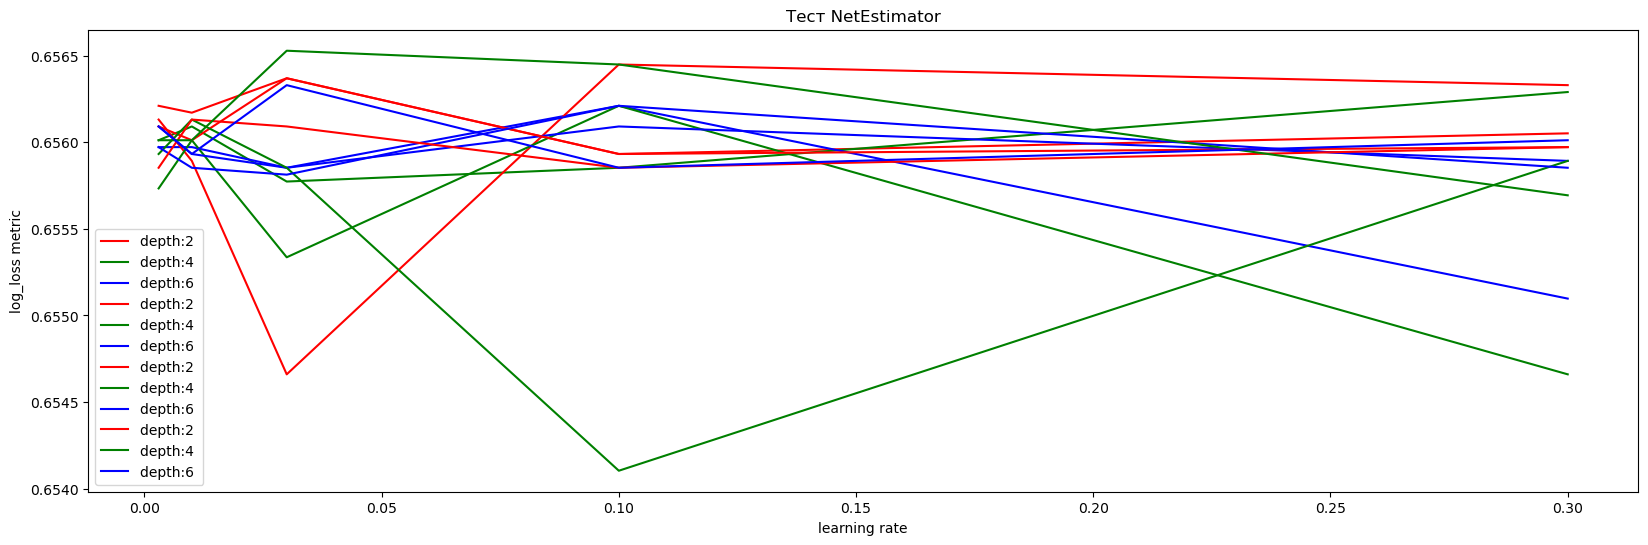

In [52]:
ResultPlotter(nt).plot()

## Проведите анализ важности факторов ДТП

Родной feature importance from lgb  

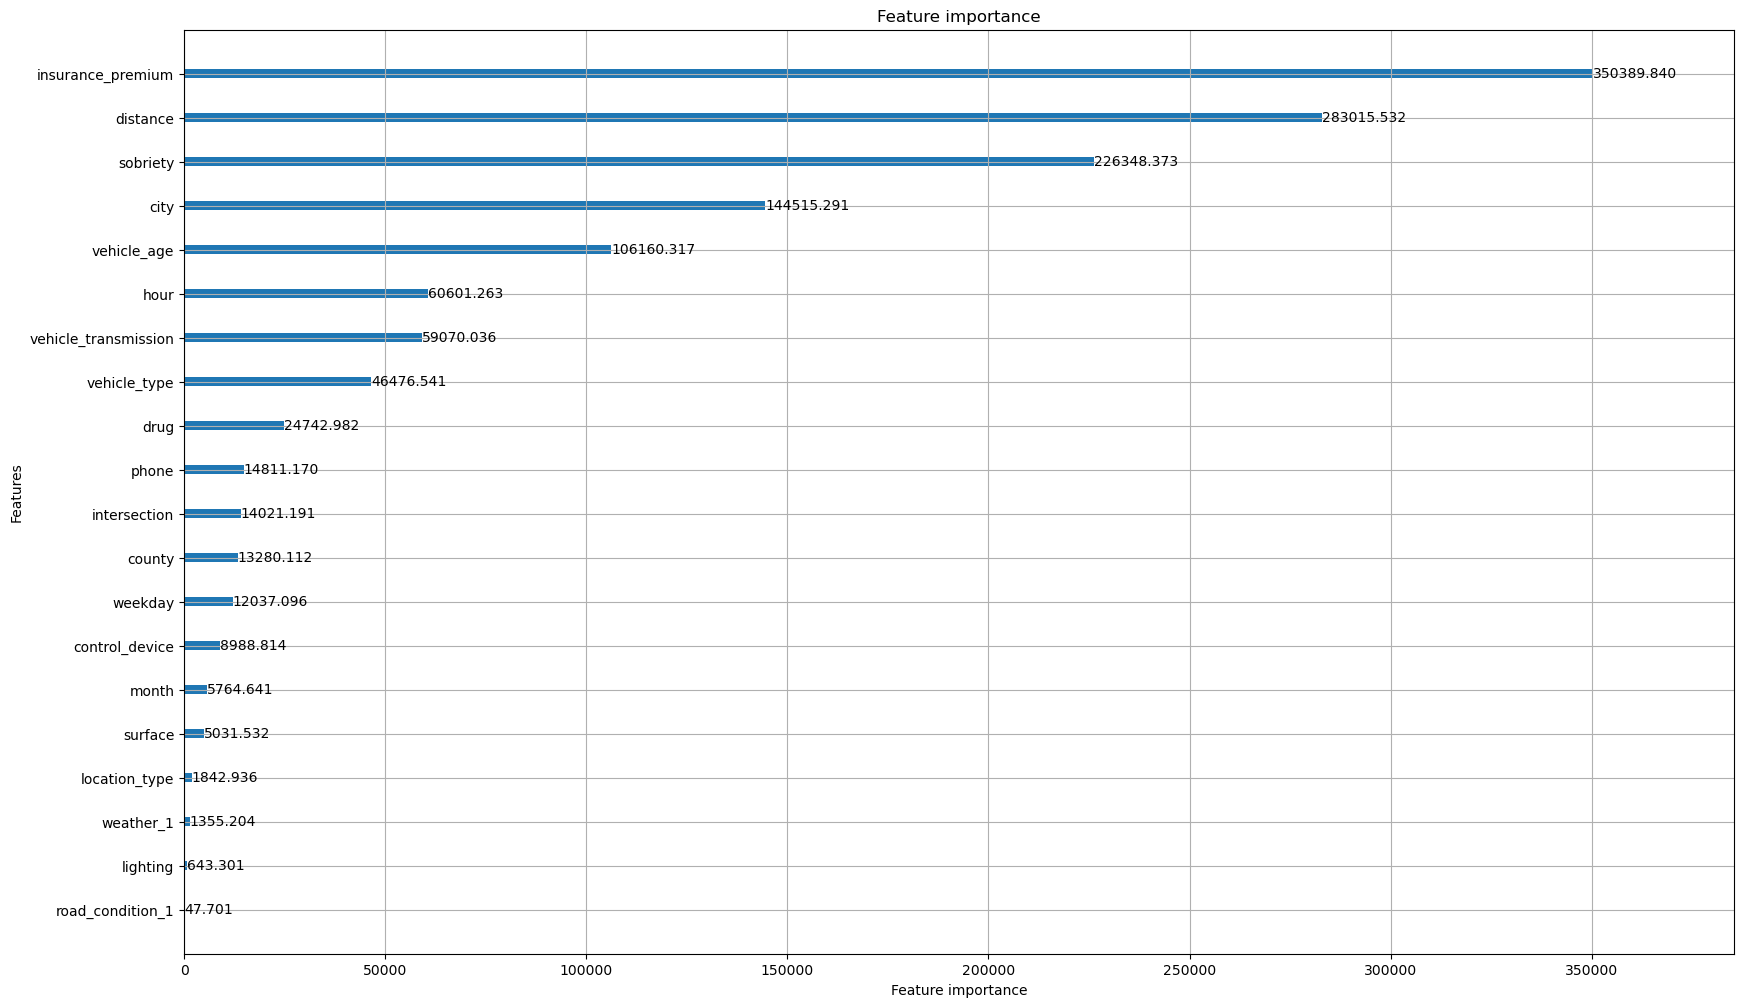

In [53]:
lgb.plot_importance(lgbm.model,importance_type='gain',max_num_features=20,figsize=(20,12) );

и оценка свой модели Catboost'ом

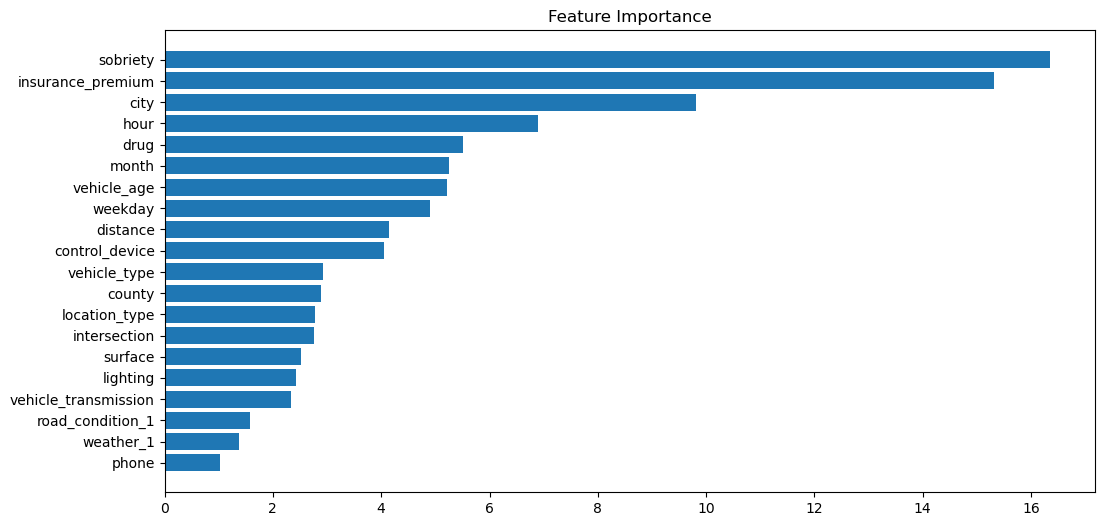

In [54]:
def native_catboost_explanation(cbst,X):
    feature_importance = cbst.model.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    fig = plt.figure(figsize=(12, 6))
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), np.array(X_te.columns)[sorted_idx])
    plt.title('Feature Importance')
native_catboost_explanation(cbst,X_te)    

при общей схожести оценок, есть отличие в третей позиции и ниже.  
Оценки моделей с помощью SHAP   

In [55]:
expl_lgbm = shap.Explainer(lgbm.model)
values_lgbm = expl_lgbm.shap_values(X_te)[1]
expl_cbst = shap.Explainer(cbst.model)
values_cbst = expl_cbst.shap_values(X_te)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


общая 

--------------------------LGBM ------------------->


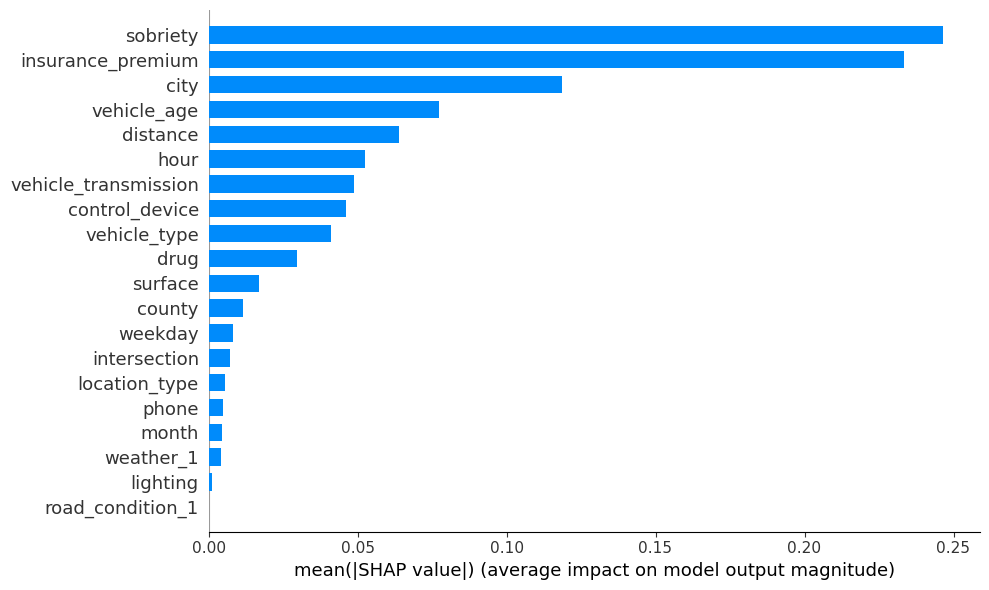

--------------------------CATBOOST------------------->


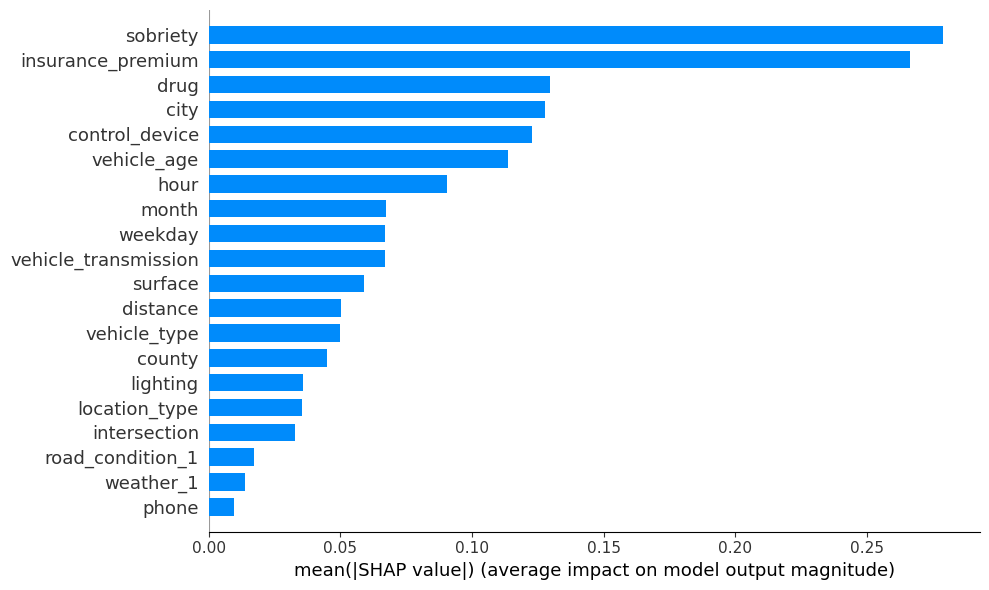

In [56]:
print('--------------------------LGBM ------------------->')
shap.summary_plot(values_lgbm, X_te,plot_type='bar',plot_size=(10,6),title='LGBM')
print('--------------------------CATBOOST------------------->')
shap.summary_plot(values_cbst, X_te,plot_type='bar',plot_size=(10,6),title='Catboost')

 и подробная

--------------------------LGBM ------------------->


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


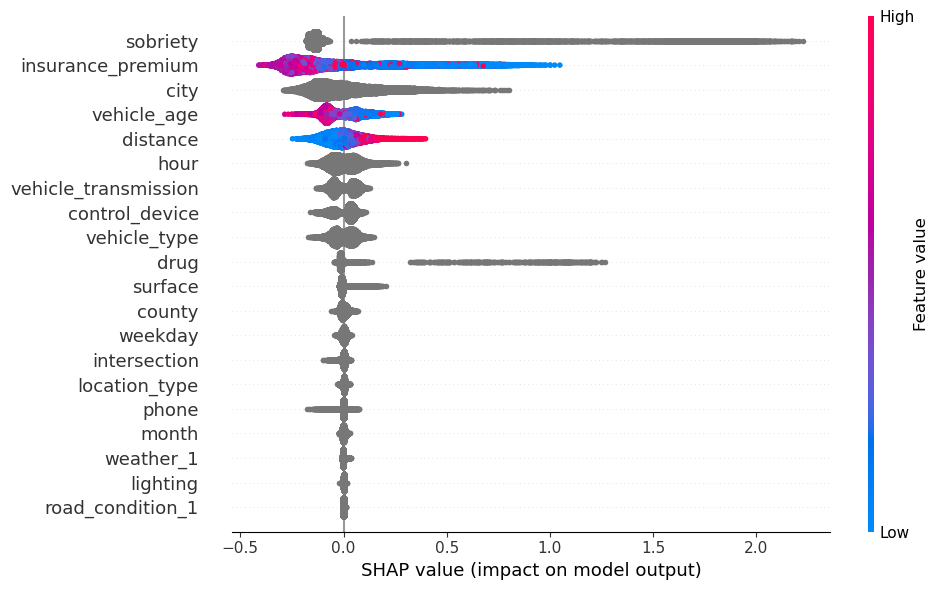

--------------------------CatBoost ------------------->


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


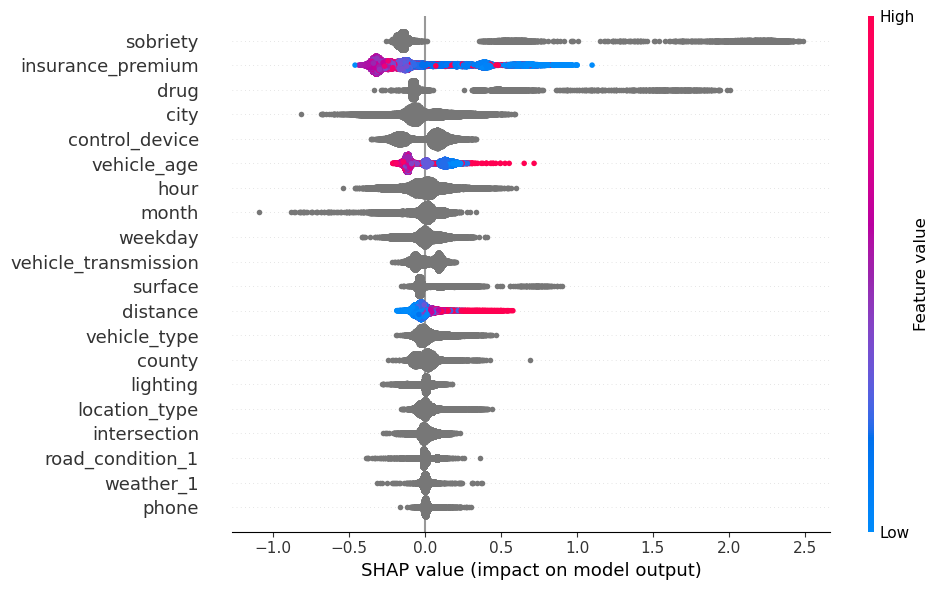

In [57]:
print('--------------------------LGBM ------------------->')
shap.summary_plot(values_lgbm, X_te,plot_type='dot',plot_size=(10,6))
print('--------------------------CatBoost ------------------->')
shap.summary_plot(values_cbst, X_te,plot_type='dot',plot_size=(10,6))

Здесь порядок важности признаков расходится еще сильнее, но в целом можно сделать определенные выводы 
Решающий вклад дают числовые признаки и признаки раздельные для участников (таблица parties)   
<b>Важнейшие признаки- стоимость страховки и состояние опьянения</b>  
Также важным признаком является  возраст машины, причем как показал и предварительный анализ, виновность ниже в середине и выше при крайних значениях.
Из прочих  признаков можно отметить довольно большое влияние города, но это может быть связано со стоимостью страховки или даже с трезвостью. Также влияет время суток(тоже возможно связано с трезвостью).
Погода, состояние дороги, освещение и использование телефона на виновность влияют меньше всего

Примитивный анализ важнейщих признаков выполнен в ч.2.

Хотя SHAP можно применить к оценке MLP классифкатора, там нужен специфический код который работает долго , и в окончательный вариант я его не включил (выводы примерно те же, но с нюансами)

#### Пересмотр задач для рабочей группы 

Исходя из собственного понимания ситуации, я бы сосредоточился на следующих задачах , имея в виду прежде всего основные причины виновности :

##### Определить влияние факторов виновности на общий материальный эффект

Посчитать долю суммы страховок в инцидентах с каждой категорией виновников к общей сумме страховок.  
Хотя такой задачи нет, она неизбежно возникнет, если работа будет продолжаться :)  

##### Проверить связь объективных факторов с виновностью участников 

На большом расстоянии от трасс и в некоторых городах виновников видимо значительно больше, хотя должно быть поровну :)
Связано ли это с другими факторами (трезвость/страховка) или это независимая тенденция?
Есть ли что-то общее у этих районов? 

##### Исследовать сложную зависимость виновности от возраста автомобиля

Это третий признак по важности
Есть непонятный миниумум виновности в середине графика , возомжно это результат взаимодействия разнонаправленных тенденций?
Пока не могу сказать , как это проверить .

##### Определить вес категорий страховки в базе инцидентов

Это важный признак и влияние его на виновность велико.  
Возможно, выделяется какая-то одна группа, на которой можно сосредоточиться (хотя по SHAP-dot не похоже)

##### Определить удельный вес пьяных инцидентов в общей базе ис сравнить с предыдущим показателем

Частично это сделано во второй части, нужно сравнение с предыдущим показателем по количиству инцидентов с учетом тяжести и по  сумме страховок.  
Если один из этих двух показателей намного больше, нужно сосредоточиться в первую очередь на нём

##### Проверить согласованность базы за предыдущие годы 

Запустить обученные и необученные модели на данных за предыдущие годы.  
Сранить результаты .  
Возможно, есть резкие изменения на которые надо обратить внимание?
Если модели  обучаются заметно лучше на прошлогодних данных, может взять их за основу?  

<b>Примечание</b>
Возможно я неправильно понял это задание и задачи слишком общие, а требуется декомпозиция на элементарные операции - фактически "написать  запрос к базе  словами".

Просьба тогда это указать .

С другой стороны, эти постановка таких задач мне все же кажестя более разумной чем "оборудовать машины трубками трезвости и камерами" - в этом я точно не разбираюсь :)

## Выводы

* Важнейшими факторами , влияющими  на  виновность являются стоимость страховки и степень опъянения, затем - возраст машины  
* Меньше вляиют место и время, нужно проверить возможную зависимость от основных признаков
* Погода и состояние дороги влияют мало
* Нужно уточнить постановку задачи - должны ли мы сосредоточиться на предсказании  виновника или на предсказании ущерба? 
* Нужно проверить корректность данных по дистанции от основной трассы
* Нужно пополнить данные за 2012 год или перейти на данные предыдущего года
* Для предсказания не только виновности но и аварийности важно иметь данные по безаварийной езде, например трафик по трассам , перекресткам и городам

<b>Disclaimer.</b>  
Я видимо слишком увлекся программированием в попытках построить универсальные классы для тестов.   
Между тем время уже поджимает а в задании курса много мелких задач в понимании которых я не уверен.  
Так что я рещил сдать его в таком виде, а то может придется что-то переделывать.  
Просьба указать в первую очередь критчные  пропуски и ошибки